### WHY FAKE NEWS IS A PROBLEM?
Fake news refers to misinformation, disinformation or mal-information which is spread through word of mouth and traditional media and more recently through digital forms of communication such as edited videos, memes, unverified advertisements and social media propagated rumours.Fake news spread through social media has become a serious problem, with the potential of it resulting in mob violence, suicides etc as a result of misinformation circulated on social media.

## STEP 1: Import necessary libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from bs4 import BeautifulSoup
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import ReduceLROnPlateau

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ansar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## STEP 2: Load the dataset
- The dataset is stored in the Google Drive folder (news) with two files (True.csv & Fake.csv).

#### **BRIEF DESCRIPTION OF DATASET**
This dataset consists of about 40000 articles consisting of fake as well as real news. Our aim is train our model so that it can correctly predict whether a given piece of news is real or fake.The fake and real news data is given in two separate datasets with each dataset consisting around 20000 articles each.


In [4]:
true = pd.read_csv("True.csv")
false = pd.read_csv("Fake.csv")

In [5]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [6]:
false.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


## STEP 3: Combine the datasets

In [7]:
true['category'] = 1
false['category'] = 0
df = pd.concat([true, false])

In [8]:
df.isnull().sum()

title       0
text        0
subject     0
date        0
category    0
dtype: int64

## STEP 4: Clean the data

In [9]:
def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'http\S+', '', text)
    stop = set(stopwords.words('english'))
    punctuation = list(string.punctuation)
    stop.update(punctuation)
    final_text = []
    for word in text.split():
        if word.strip().lower() not in stop:
            final_text.append(word.strip())
    cleaned_text = " ".join(final_text)

    # Check if the cleaned text is empty
    if not cleaned_text:
        cleaned_text = "placeholder"  # Add a placeholder word

    return cleaned_text

df['clean_text'] = df['text'].apply(clean_text)

C:\Users\ansar\AppData\Local\Temp\ipykernel_7924\3730861894.py:2: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  text = BeautifulSoup(text, "html.parser").get_text()


## STEP 5: Word cloud for real and fake text


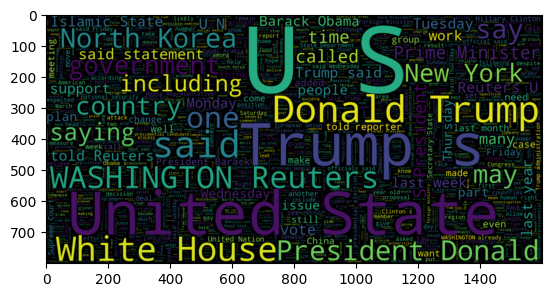

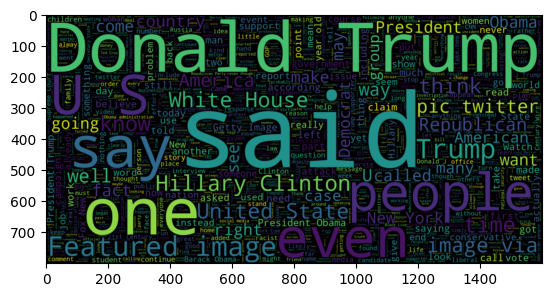

In [10]:
# Word cloud for real and fake text
def plot_wordcloud(category):
    wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(" ".join(df[df.category == category].clean_text))
    plt.imshow(wc, interpolation='bilinear')
    plt.show()

# Plot word cloud for real text
plot_wordcloud(1)

# Plot word cloud for fake text
plot_wordcloud(0)


## STEP 6: Split the data into training and testing sets

In [11]:
x_train, x_test, y_train, y_test = train_test_split(df.clean_text, df.category, random_state=0)

## STEP 7: Tokenizing text and padding sequences

In [12]:
max_features = 10000
maxlen = 300
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(tokenized_train, maxlen=maxlen)
tokenized_test = tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(tokenized_test, maxlen=maxlen)

In [13]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

# Step 11: Load pre-trained GloVe embeddings
EMBEDDING_FILE = 'glove.twitter.27B.100d.txt'

def load_embeddings(embedding_file, word_index, max_features):
    embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(embedding_file, encoding='utf-8'))
    all_embs = np.stack(list(embeddings_index.values()))
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix, embed_size

embedding_matrix, embed_size = load_embeddings(EMBEDDING_FILE, tokenizer.word_index, max_features)

## STEP 8: Model definition and training

In [ ]:
batch_size = 256
epochs = 3
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

model = Sequential()
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(LSTM(units=128, return_sequences=True, recurrent_dropout=0.25, dropout=0.25))
model.add(LSTM(units=64, recurrent_dropout=0.1, dropout=0.1))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=batch_size, validation_data=(x_test, y_test), epochs=epochs, callbacks=[learning_rate_reduction])


c:\Users\ansar\anaconda3\envs\new_env\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
132/132 ━━━━━━━━━━━━━━━━━━━━ 1056s 8s/step - accuracy: 0.8259 - loss: 0.3824 - val_accuracy: 0.9628 - val_loss: 0.1103 - learning_rate: 0.0010
Epoch 2/3
132/132 ━━━━━━━━━━━━━━━━━━━━ 1137s 9s/step - accuracy: 0.9335 - loss: 0.1649 - val_accuracy: 0.9517 - val_loss: 0.1316 - learning_rate: 0.0010
Epoch 3/3
 95/132 ━━━━━━━━━━━━━━━━━━━━ 8:51 14s/step - accuracy: 0.9453 - loss: 0.1459

## STEP 9: Model evaluation and analysis

In [14]:
print("Accuracy on Training Data:", model.evaluate(x_train, y_train)[1] * 100, "%")
print("Accuracy on Testing Data:", model.evaluate(x_test, y_test)[1] * 100, "%")

1053/1053 ━━━━━━━━━━━━━━━━━━━━ 202s 192ms/step - accuracy: 0.9737 - loss: 0.0858
Accuracy on Training Data: 97.26486802101135 %
351/351 ━━━━━━━━━━━━━━━━━━━━ 69s 198ms/step - accuracy: 0.9674 - loss: 0.1012
Accuracy on Testing Data: 97.06013202667236 %


##### Model Evaluation Results
Training Accuracy: ~97.26%
Testing Accuracy: ~97.06%
This means the model performs very well on both the training and testing data, indicating strong generalization and minimal overfitting.


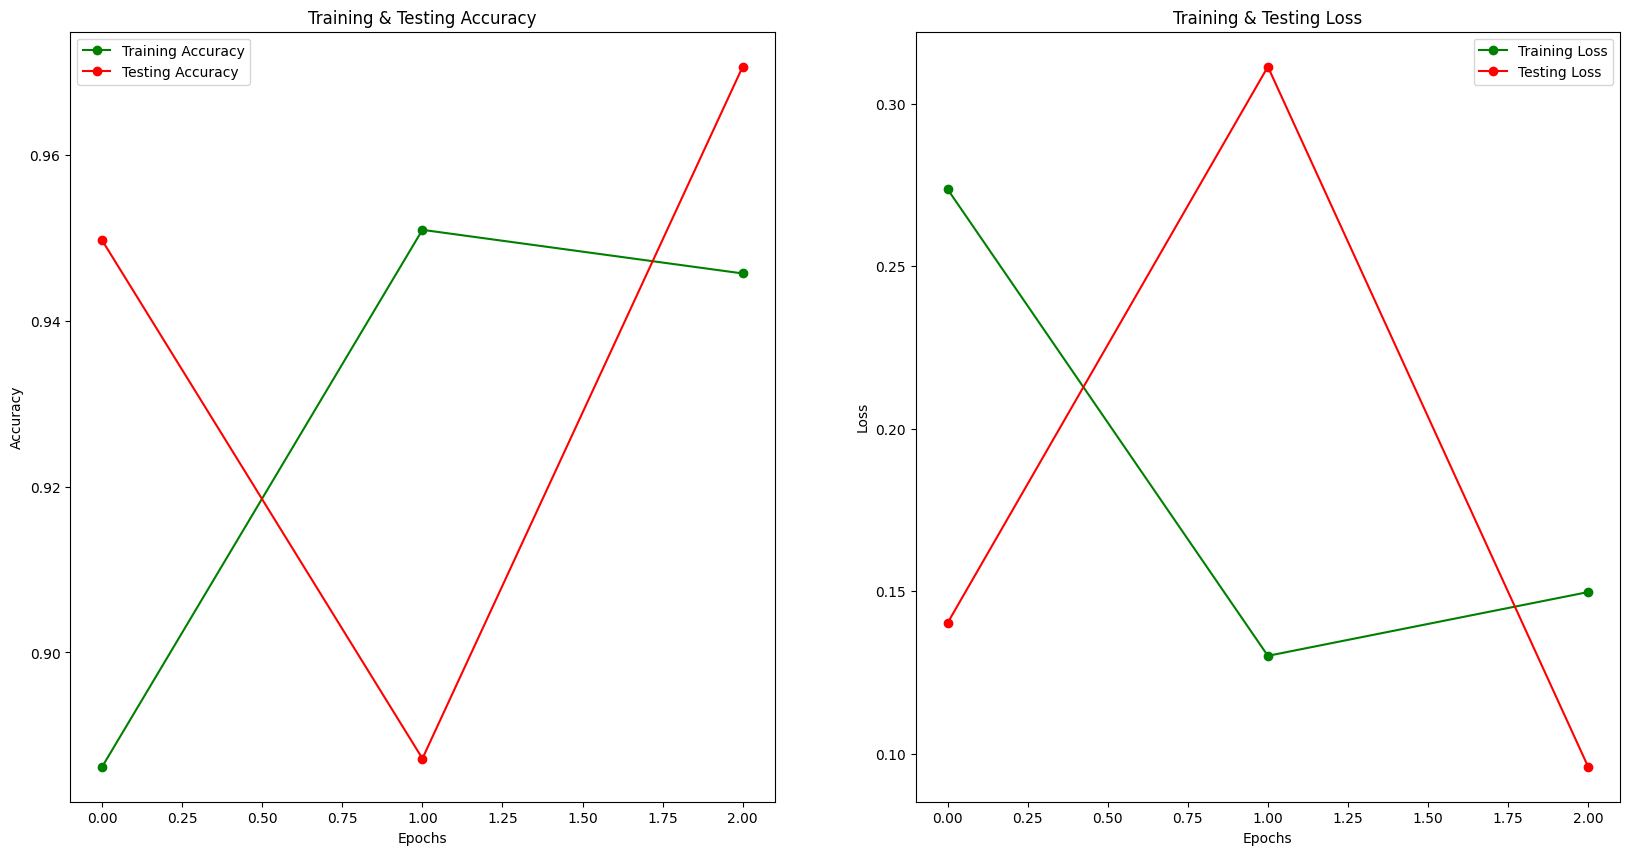

In [15]:
# Get the actual number of epochs from the history object
actual_epochs = len(history.history['accuracy'])

epochs = [i for i in range(actual_epochs)]  # Adjust epochs array based on the actual number of epochs
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20, 10)

ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label='Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label='Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

## Step 10: Confusion Matrix and Classification Report

351/351 ━━━━━━━━━━━━━━━━━━━━ 58s 160ms/step
              precision    recall  f1-score   support

        Fake       0.99      0.95      0.97      5858
    Not Fake       0.95      0.99      0.97      5367

    accuracy                           0.97     11225
   macro avg       0.97      0.97      0.97     11225
weighted avg       0.97      0.97      0.97     11225



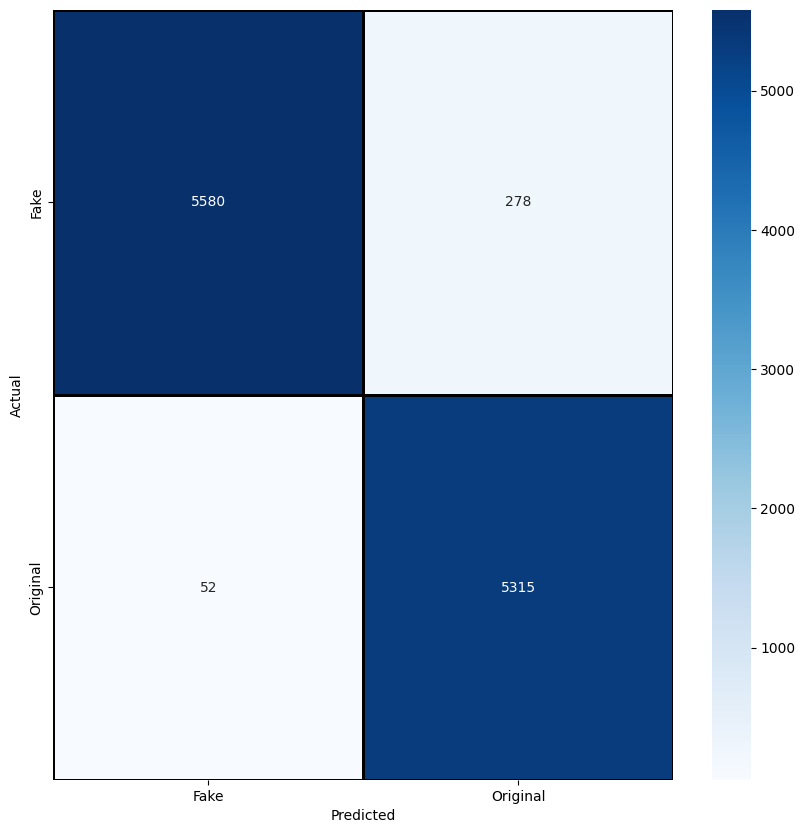

In [16]:
# Use predict method to get predicted probabilities
pred_probabilities = model.predict(x_test)

# Threshold predicted probabilities to get predicted classes
pred = (pred_probabilities > 0.5).astype('int32')

print(classification_report(y_test, pred, target_names=['Fake', 'Not Fake']))
cm = confusion_matrix(y_test, pred)
cm = pd.DataFrame(cm, index=['Fake', 'Original'], columns=['Fake', 'Original'])

plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=['Fake', 'Original'], yticklabels=['Fake', 'Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


#### Confusion Matrix
Fake News (class 0):
Correctly identified (True Positives): 95% of 5858 ≈ 5565
Misclassified as Not Fake (False Negatives): 5% of 5858 ≈ 293
Not Fake News (class 1):
Correctly identified (True Negatives): 99% of 5367 ≈ 5313
Misclassified as Fake (False Positives): 1% of 5367 ≈ 54

### Conclusion: The model is highly effective and reliable for this binary classification task, making it suitable for practical fake news detection.

### Deployment

In [ ]:
import pickle

# Save the trained model
model.save('fake_news_lstm.h5')

# Save the tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print('Model and tokenizer saved!')

NameError: name 'model' is not defined